In [1]:
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output

import sys
np.set_printoptions(threshold=sys.maxsize)

np.random.seed(14)

In [2]:
def lin2db(x):
    return 10.0*np.log10(x)

def db2lin(x):
    return 10.0**(x/10.0)

def lin2dbm(x):
    return 10.0*np.log10(x)+30.0

def dbm2lin(x):
    return 10.0**(x/10.0 - 3.0)

In [3]:
def eCDF(data):
    x = np.sort(data)
    y = np.arange(0, len(data)) / len(data)

    return x, y 

In [4]:
total_bandwidth = 100e6 # [Hz]
tx_power = 1 # [W]

environment_constant = 1e-4
pathloss_constant = 4

ref_distance = 1 # [m]

In [5]:
def random_ue_positions(num_ue, cov_side):
    ''' 
    Returns a random position vector within the coverage area.
    
    Parameters
    ----------
    cov_side : int, float
        The side [in m] of the coverage area.
    num_ue : int
        The number of UEs.
    '''
    
    ue_positions = np.zeros((num_ue, 2))
    
    for ue in range(num_ue):
        ue_positions[ue] = [np.random.rand() * cov_side, np.random.rand() * cov_side]
        
    return ue_positions

In [6]:
def ap_positions(num_ap, cov_side):
    ''' 
    Returns the APs positions based on the number of APs.
    
    Parameters
    ----------
    num_ap : int
        The number of APs.
    cov_side : int, float
        The side [in m] of coverage area.
    '''
    
    if np.sqrt(num_ap).is_integer():
        
        side_ap_quantity = int(np.sqrt(num_ap))
        
        ap_area_side = cov_side // side_ap_quantity
        
        x_pos, y_pos = np.meshgrid(np.arange(0.5 * ap_area_side,
                                             cov_side,
                                             ap_area_side),
                                   np.arange(0.5 * ap_area_side,
                                             cov_side,
                                             ap_area_side))
 
        aps_pos = np.column_stack((x_pos.ravel() + y_pos.ravel()*1j)).reshape((num_ap, 1))
    
        return aps_pos
    
    else:
        
        print('Number of APs must be a perfect square')

In [7]:
def distance(ue_pos, ap_pos, ref_distance=1):
    ''' 
    Returns the distance [in m] between an UE and an AP. If distance is lower than reference distance, it returns the reference distance.
    
    Parameters
    ----------
    ue_pos : int, float
        The UE position.
    ap_pos : int, float
        The AP position.
    ref_distance : int, float
        The reference distance [in m] from which the gain is calculated.
    '''

    dis_matrix = np.zeros((ue_pos.shape[0], ap_pos.shape[0]))
    
    for ue in range(ue_pos.shape[0]):
        for ap in range(ap_pos.shape[0]):
            dis = np.absolute(ue_pos[ue] - ap_pos[ap]) 
            
            if dis[0] >= ref_distance:
                dis_matrix[ue, ap] = dis[0]
            
            else:
                dis_matrix[ue, ap] = ref_distance

    return dis_matrix

In [8]:
def shadowing(std, num_ue, num_ap):

    return np.random.lognormal(sigma = std, size = (num_ue, num_ap))

In [9]:
def rayleigh(std, num_ue, num_ap, num_ch):

    return np.sqrt((std*np.random.randn(num_ch, num_ue, num_ap))**2 + (std*np.random.randn(num_ch, num_ue, num_ap))**2) 

In [10]:
def channel(distance, shadowing, rayleigh):

    channel_mat = shadowing * (environment_constant / (distance ** pathloss_constant)) * rayleigh

#     if rayleigh.shape[0] > 1:
        
#         for row in range(rayleigh.shape[1]):
    
#             channel_mat[np.random.randint(0, rayleigh.shape[0]), row, :] = np.zeros(rayleigh.shape[2])

#     for row in range(rayleigh.shape[1]):

#         max_channel = np.max(channel_mat[:, row, :])
        
#         for col in range(rayleigh.shape[2]):

#             if channel_mat[:, row, col] != max_channel:

#                 channel_mat[:, row, col] = 0

    return channel_mat

In [11]:
def sinr(power_vector, channel, noise_p):
    
    sinr_matrix = np.zeros(channel.shape)
    sinr_vector = np.zeros(channel.shape[1])

    
    for ch in range(channel.shape[0]):

        for ue_index in range(channel.shape[1]):

            max_signal, max_index = max(channel[ch, ue_index, :]) * power_vector[ue_index][0], np.argmax(channel[ch, ue_index, :])
                        
            channel_sum = 0
            
            for row in range(channel.shape[1]):
                                
                channel_sum += channel[ch, row, max_index] * power_vector[row][0]
                
            sinr_vector[ue_index] = max_signal / ((channel_sum - max_signal) + noise_p)

    return lin2db(sinr_vector)

In [12]:
def snr(power_vector, channel, noise_p):

    snr_matrix = np.zeros(channel.shape)
    snr_vector = np.zeros(channel.shape[1])

    snr_matrix = (power_vector.reshape((snr_matrix.shape[0], 1)) * channel) / noise_p

    for row in range(snr_matrix.shape[0]):

        snr_vector[row] = snr_matrix[:, row, :].max()

    return lin2db(snr_vector)

In [13]:
def updown_dpc(channel, pmax, pmin, step, sinr_target, total_time, power_noise):

    power_vector = pmax * np.ones((1, channel.shape[1])).T 
    
    power_sum = np.zeros(total_time)

    power_evolution = np.zeros((channel.shape[1], total_time))

    sinr_evolution = np.zeros((channel.shape[1], total_time))
    
    time = 0

    for t in range(total_time):

        power_sum[t] = sum(power_vector.reshape((1, channel.shape[1]))[0])

        power_evolution[:, t] = power_vector.reshape(channel.shape[1])

        sinr_vector = sinr(dbm2lin(power_vector), channel, power_noise).reshape((1, channel.shape[1])).T

        sinr_evolution[:, t] = sinr_vector.reshape(channel.shape[1])

        #print('power vector before', power_vector)
        
        #print('step', step * np.sign(sinr_target - sinr_vector))
        
        power_vector = power_vector + step * np.sign(sinr_target - sinr_vector)

        #print('power vector after', power_vector)
        
        for p in range(power_vector.shape[0]):

            if power_vector[p] > pmax:

                power_vector[p] = pmax

            elif power_vector[p] < pmin:

                power_vector[p] = pmin

        time += 1
            
    return power_vector, power_sum, power_evolution, sinr_evolution

In [14]:
def esnp_maxmin(channel, pmax, pmin, step, delta, epsilon, total_time, power_noise):

    num_ue = channel.shape[1]

    power_evolution = np.zeros((num_ue, total_time))

    sinr_evolution = np.zeros((num_ue, total_time))
    
    function_evolution = np.zeros(total_time)
    
    # Set of available transmit powers [dBm] for UEs to choose from
    
    available_tpower = np.array([pmin + step * m for m in range(int((pmax - pmin) / step + 1))])

    
    # Define power vector, sinr vector and objective function

    vetor = np.zeros((num_ue, 1))
    
    power_vec = pmax * np.ones((num_ue, 1))
    sinr_vec = 0
    maxmin_func = 0

    
    # Start iterations

    for t in range(total_time):

        sinr_vec = db2lin(sinr(dbm2lin(power_vec), channel, power_noise))
        min_sinr = np.min(sinr_vec)
            
        # Evaluate sumrate function

        if min_sinr > maxmin_func:
                            
            maxmin_func = min_sinr
        
            vetor = power_vec.copy()
          
            #print('\n DENTRO', vetor, '\n')
            
        #print('min_sinr:', min_sinr, 'maxmin_func:', maxmin_func)
        
        #print(vetor)
            
        sinr_evolution[:, t] = sinr(dbm2lin(vetor), channel, power_noise).reshape(num_ue)
        
        power_evolution[:, t] = vetor.reshape(num_ue)
        
        function_evolution[t] = lin2db(maxmin_func) 
                
        # Set power vector based to delta and epsilon
        
        rand_value = np.random.rand()

        if rand_value < epsilon:

            for value in range(power_vec.shape[0]):

                # Choose power randomly from the available power values
                
                power_vec[value] = available_tpower[np.random.randint(available_tpower.shape[0])]
        
        else:

            # Set power based on delta

            power_vec = vetor + delta * (np.random.rand(num_ue, 1) - 0.5)


        # Keep the power values between power max and power min
            
        for value in range(power_vec.shape[0]):

            if power_vec[value] > pmax:

                power_vec[value] = pmax

            elif power_vec[value] < pmin:

                power_vec[value] = pmin

            else:

                pass
    
    return vetor, power_evolution, sinr_evolution, function_evolution

In [30]:
def esnp_sumrate(channel, pmax, pmin, step, delta, epsilon, total_time, power_noise):

    num_ue = channel.shape[1]

    power_evolution = np.zeros((num_ue, total_time))

    sinr_evolution = np.zeros((num_ue, total_time))
    
    function_evolution = np.zeros(total_time)
    
    # Set of available transmit powers [dBm] for UEs to choose from
    
    available_tpower = np.array([pmin + step * m for m in range(int((pmax - pmin) / step + 1))])

    
    # Define power vector, sinr vector and objective function

    power = np.zeros((num_ue, 1))
    
    power_vec = pmax * np.ones((num_ue, 1))
    sinr_vec = 0
    sumrate_func = 0

    
    # Start iterations

    for t in range(total_time):

        sinr_vec = sinr(dbm2lin(power_vec), channel, power_noise)
        capacity_sum = sum(capacity(total_bandwidth, num_ch, sinr_vec))

        # Evaluate sumrate function
        
        if capacity_sum > sumrate_func:

            sumrate_func = capacity_sum
            
            power = power_vec.copy()
        
        sinr_evolution[:, t] = sinr(dbm2lin(power), channel, power_noise).reshape(num_ue)
        
        power_evolution[:, t] = power.reshape(num_ue)
            
        function_evolution[t] = sumrate_func
        
        # Set power vector based to delta and epsilon
        
        rand_value = np.random.rand()

        if rand_value < epsilon:
            
            for value in range(power_vec.shape[0]):

                # Choose power randomly from the available power values
                
                power_vec[value] = available_tpower[np.random.randint(available_tpower.shape[0])]
        
        else:

            # Set power based on delta

            power_vec = power + delta * (np.random.rand(num_ue, 1) - 0.5)


        # Keep the power values between power max and power min
            
        for value in range(power_vec.shape[0]):

            if power_vec[value] > pmax:

                power_vec[value] = pmax

            elif power_vec[value] < pmin:

                power_vec[value] = pmin

            else:

                pass

    #print(random_power/total_time)
    
    return power, power_evolution, sinr_evolution, function_evolution

In [ ]:
def esnp_maxproduct(channel, pmax, pmin, step, delta, epsilon, total_time, power_noise):

    num_ue = channel.shape[1]

    power_evolution = np.zeros((num_ue, total_time))

    sinr_evolution = np.zeros((num_ue, total_time))
    
    function_evolution = np.zeros(total_time)
    
    # Set of available transmit powers [dBm] for UEs to choose from
    
    available_tpower = np.array([pmin + step * m for m in range(int((pmax - pmin) / step + 1))])

    
    # Define power vector, sinr vector and objective function

    power = np.zeros((num_ue, 1))
    
    power_vec = pmax * np.ones((num_ue, 1))
    sinr_vec = 0
    maxproduct_func = 0

    
    # Start iterations

    for t in range(total_time):

        sinr_vec = sinr(dbm2lin(power_vec), channel, power_noise)
        min_sinr = min(db2lin(sinr_vec))
        capacity_sum = sum(capacity(total_bandwidth, num_ch, sinr_vec))
        
        # Evaluate sumrate function
        
        if min_sinr * > sumrate_func:

            sumrate_func = capacity_sum
            
            power = power_vec.copy()
        
        sinr_evolution[:, t] = sinr(dbm2lin(power), channel, power_noise).reshape(num_ue)
        
        power_evolution[:, t] = power.reshape(num_ue)
            
        function_evolution[t] = sumrate_func
        
        # Set power vector based to delta and epsilon
        
        rand_value = np.random.rand()

        if rand_value < epsilon:
            
            for value in range(power_vec.shape[0]):

                # Choose power randomly from the available power values
                
                power_vec[value] = available_tpower[np.random.randint(available_tpower.shape[0])]
        
        else:

            # Set power based on delta

            power_vec = power + delta * (np.random.rand(num_ue, 1) - 0.5)


        # Keep the power values between power max and power min
            
        for value in range(power_vec.shape[0]):

            if power_vec[value] > pmax:

                power_vec[value] = pmax

            elif power_vec[value] < pmin:

                power_vec[value] = pmin

            else:

                pass

    #print(random_power/total_time)
    
    return power, power_evolution, sinr_evolution, function_evolution

In [16]:
def capacity(total_bandwidth, num_ch, sinr):
    
    return ((total_bandwidth / num_ch) * np.log2(1 + db2lin(sinr))) / 1e6

In [17]:
def power_noise(total_bandwidth, num_ch):
    
    return (total_bandwidth/num_ch) * 1e-20

In [18]:
num_ue = 4
num_ap = 4
num_ch = 1

cov_side_noise = 1000 # [m]
cov_side_interference = 100 # [m]
seeds = 1

sh_std = 2
mp_std = 1 / np.sqrt(2) 

In [19]:
p_max = 30 # [dBm]
p_min = 0 # [dBm]

total_time = 300

step = 1 # [dBm]
sinr_target = 1 # [dB]

In [20]:
class Simulation_interferencelimited:

    def __init__(self):
    
        self.total_sinr_npc = np.zeros((num_ue, seeds))
        self.total_sinr_ud = np.zeros((num_ue, seeds))
        self.total_sinr_maxmin = np.zeros((num_ue, seeds))
        self.total_sinr_sumrate = np.zeros((num_ue, seeds))
        
        self.total_capacity_npc = np.zeros((num_ue, seeds))
        self.total_capacity_ud = np.zeros((num_ue, seeds))
        self.total_capacity_maxmin = np.zeros((num_ue, seeds))
        self.total_capacity_sumrate = np.zeros((num_ue, seeds))
        
        self.each_power_evolution_ud = np.zeros((num_ue, total_time, seeds))
        self.total_power_evolution_ud = np.zeros((total_time, seeds))
        self.each_sinr_evolution_ud = np.zeros((num_ue, total_time, seeds))
    
        self.each_power_evolution_maxmin = np.zeros((num_ue, total_time, seeds))
        self.total_power_evolution_maxmin = np.zeros((total_time, seeds))
        self.each_sinr_evolution_maxmin = np.zeros((num_ue, total_time, seeds))
    
        self.each_power_evolution_sumrate = np.zeros((num_ue, total_time, seeds))
        self.total_power_evolution_sumrate = np.zeros((total_time, seeds))
        self.each_sinr_evolution_sumrate = np.zeros((num_ue, total_time, seeds))
    
        self.total_EE_npc = np.zeros(seeds)
        self.total_EE_ud = np.zeros(seeds)
        self.total_EE_maxmin = np.zeros(seeds)
        self.total_EE_sumrate = np.zeros(seeds)
        
        self.maxmin_evolution = np.zeros((total_time, seeds))
        self.sumrate_evolution = np.zeros((total_time, seeds))

    def simulate(self):

        noise_p = power_noise(total_bandwidth, num_ch)
        
        for seed in range(seeds):
            
            # Study case values
            
            ue_pos = np.array([[22.538 + 20.333j], 
                               [56.679 + 32.188j], 
                               [76.551 + 14.688j], 
                               [26.595 + 70.239j]])
            
            ap_pos = ap_positions(num_ap, cov_side_interference)
            distances = distance(ue_pos, ap_pos)
            
            shadowing_matrix = np.array([[5.3434e-2, 2.8731e-1, 1.9691e-2, 7.3013e-1], 
                                         [3.2318, 1.5770, 2.6449e-1, 5.6379], 
                                         [6.1470e-3, 1.1424, 2.6826e-1, 4.5709], 
                                         [1.3485e-1, 4.6690e-1, 7.8250e-1, 1.6742]])
             
            rayleigh_matrix = np.array([[1.248699, 3.248041, 0.772754, 0.708962], 
                                        [0.498887, 0.104890, 0.647280, 0.940906], 
                                        [0.382966, 0.682700, 1.891256, 0.327100], 
                                        [0.065737, 0.649500, 1.981107, 1.259538]]).reshape((num_ch, num_ue, num_ap))
    
            
            # Channel coefficients matrix
            
            random_matrix = channel(distances, shadowing_matrix, rayleigh_matrix)
    
            
            # No power control (or max power)
            
            npc_power = p_max * np.ones(num_ue).reshape((1, random_matrix.shape[1])).T
    
            
            # Up-down Distributed Power Control (UD-DPC)
            
            updown = updown_dpc(random_matrix, p_max, p_min, step, sinr_target, total_time, noise_p)
            
            ud_power = updown[0].reshape((1, random_matrix.shape[1])).T
            self.total_power_evolution_ud[:, seed] = updown[1]
            self.each_power_evolution_ud[:, :, seed] = updown[2]
    
            self.each_sinr_evolution_ud[:, :, seed] = updown[3]
    
    
            # Exhaustive Search with Neighborhood preference (ESNP)
            
            sumrate = esnp_sumrate(random_matrix, p_max, p_min, step, 10, 0.5, total_time, noise_p)
            sumrate_power = sumrate[0]
            self.each_power_evolution_sumrate[:, :, seed] = sumrate[1]
            self.each_sinr_evolution_sumrate[:, :, seed] = sumrate[2]
            self.sumrate_evolution[:, seed] = sumrate[3]
                    
            maxmin = esnp_maxmin(random_matrix, p_max, p_min, step, 10, 0.5, total_time, noise_p)
            maxmin_power = maxmin[0]
            self.each_power_evolution_maxmin[:, :, seed] = maxmin[1]
            self.each_sinr_evolution_maxmin[:, :, seed] = maxmin[2]
            self.maxmin_evolution[:, seed] = maxmin[3]
            
            # SINR 
            
            system_sinr_npc = sinr(dbm2lin(npc_power), random_matrix, noise_p)
            system_sinr_ud = sinr(dbm2lin(ud_power), random_matrix, noise_p)
            system_sinr_maxmin = sinr(dbm2lin(maxmin_power), random_matrix, noise_p)
            system_sinr_sumrate = sinr(dbm2lin(sumrate_power), random_matrix, noise_p)
            
            self.total_sinr_npc[:, seed] = system_sinr_npc
            self.total_sinr_ud[:, seed] = system_sinr_ud
            self.total_sinr_maxmin[:, seed] = system_sinr_maxmin
            self.total_sinr_sumrate[:, seed] = system_sinr_sumrate
    
            
            # Capacity
    
            capacity_npc = capacity(total_bandwidth, num_ch, system_sinr_npc)
            capacity_ud = capacity(total_bandwidth, num_ch, system_sinr_ud)
            capacity_maxmin = capacity(total_bandwidth, num_ch, system_sinr_maxmin)
            capacity_sumrate = capacity(total_bandwidth, num_ch, system_sinr_sumrate)
            
            self.total_capacity_npc[:, seed] = capacity_npc
            self.total_capacity_ud[:, seed] = capacity_ud
            self.total_capacity_maxmin[:, seed] = capacity_maxmin
            self.total_capacity_sumrate[:, seed] = capacity_sumrate
    
            
            # Energy Efficiency
            
            self.total_EE_npc[seed] = np.sum(capacity_npc) / np.sum(dbm2lin(npc_power))
            self.total_EE_ud[seed] = np.sum(capacity_ud) / np.sum(dbm2lin(ud_power))
            self.total_EE_maxmin[seed] = np.sum(capacity_maxmin) / np.sum(dbm2lin(maxmin_power))
            self.total_EE_sumrate[seed] = np.sum(capacity_sumrate) / np.sum(dbm2lin(sumrate_power))
            
            clear_output(wait=True)

In [21]:
class Simulation_noiselimited:

    def __init__(self):
    
        self.total_sinr_npc = np.zeros((num_ue, seeds))
        self.total_sinr_ud = np.zeros((num_ue, seeds))
        self.total_sinr_maxmin = np.zeros((num_ue, seeds))
        self.total_sinr_sumrate = np.zeros((num_ue, seeds))
        
        self.total_capacity_npc = np.zeros((num_ue, seeds))
        self.total_capacity_ud = np.zeros((num_ue, seeds))
        self.total_capacity_maxmin = np.zeros((num_ue, seeds))
        self.total_capacity_sumrate = np.zeros((num_ue, seeds))
        
        self.each_power_evolution_ud = np.zeros((num_ue, total_time, seeds))
        self.total_power_evolution_ud = np.zeros((total_time, seeds))
        self.each_sinr_evolution_ud = np.zeros((num_ue, total_time, seeds))
    
        self.each_power_evolution_maxmin = np.zeros((num_ue, total_time, seeds))
        self.total_power_evolution_maxmin = np.zeros((total_time, seeds))
        self.each_sinr_evolution_maxmin = np.zeros((num_ue, total_time, seeds))
    
        self.each_power_evolution_sumrate = np.zeros((num_ue, total_time, seeds))
        self.total_power_evolution_sumrate = np.zeros((total_time, seeds))
        self.each_sinr_evolution_sumrate = np.zeros((num_ue, total_time, seeds))
    
        self.total_EE_npc = np.zeros(seeds)
        self.total_EE_ud = np.zeros(seeds)
        self.total_EE_maxmin = np.zeros(seeds)
        self.total_EE_sumrate = np.zeros(seeds)

        self.sumrate_evolution = np.zeros((total_time, seeds))
        self.maxmin_evolution = np.zeros((total_time, seeds))
        
    def simulate(self):

        noise_p = power_noise(total_bandwidth, num_ch)
        
        for seed in range(seeds):
            
            # Study case values
            
            ue_pos = np.array([[225.38 + 203.33j], 
                               [566.79 + 321.88j], 
                               [765.51 + 146.88j], 
                               [265.95 + 702.39j]])
            
            ap_pos = ap_positions(num_ap, cov_side_noise)
            distances = distance(ue_pos, ap_pos)
            
            shadowing_matrix = np.array([[5.3434e-2, 2.8731e-1, 1.9691e-2, 7.3013e-1], 
                                         [3.2318, 1.5770, 2.6449e-1, 5.6379], 
                                         [6.1470e-3, 1.1424, 2.6826e-1, 4.5709], 
                                         [1.3485e-1, 4.6690e-1, 7.8250e-1, 1.6742]])
             
            rayleigh_matrix = np.array([[1.248699, 3.248041, 0.772754, 0.708962], 
                                        [0.498887, 0.104890, 0.647280, 0.940906], 
                                        [0.382966, 0.682700, 1.891256, 0.327100], 
                                        [0.065737, 0.649500, 1.981107, 1.259538]]).reshape((num_ch, num_ue, num_ap))
    
            
            # Channel coefficients matrix
            
            random_matrix = channel(distances, shadowing_matrix, rayleigh_matrix)
    
            
            # No power control (or max power)
            
            npc_power = p_max * np.ones(num_ue).reshape((1, random_matrix.shape[1])).T
    
            
            # Up-down Distributed Power Control (UD-DPC)
            
            updown = updown_dpc(random_matrix, p_max, p_min, step, sinr_target, total_time, noise_p)
            
            ud_power = updown[0].reshape((1, random_matrix.shape[1])).T
            self.total_power_evolution_ud[:, seed] = updown[1]
            self.each_power_evolution_ud[:, :, seed] = updown[2]
    
            self.each_sinr_evolution_ud[:, :, seed] = updown[3]
    
    
            # Exhaustive Search with Neighborhood preference (ESNP)
            
            sumrate = esnp_sumrate(random_matrix, p_max, p_min, step, 10, 0.5, total_time, noise_p)
            sumrate_power = sumrate[0]
            self.each_power_evolution_sumrate[:, :, seed] = sumrate[1]
            self.each_sinr_evolution_sumrate[:, :, seed] = sumrate[2]
            self.sumrate_evolution[:, seed] = sumrate[3]    
                
            maxmin = esnp_maxmin(random_matrix, p_max, p_min, step, 10, 0.5, total_time, noise_p)
            maxmin_power = maxmin[0]
            self.each_power_evolution_maxmin[:, :, seed] = maxmin[1]
            self.each_sinr_evolution_maxmin[:, :, seed] = maxmin[2]
            self.maxmin_evolution[:, seed] = maxmin[3]
            
            # SINR 
            
            system_sinr_npc = sinr(dbm2lin(npc_power), random_matrix, noise_p)
            system_sinr_ud = sinr(dbm2lin(ud_power), random_matrix, noise_p)            
            system_sinr_maxmin = sinr(dbm2lin(maxmin_power), random_matrix, noise_p)
            system_sinr_sumrate = sinr(dbm2lin(sumrate_power), random_matrix, noise_p)
            
            self.total_sinr_npc[:, seed] = system_sinr_npc
            self.total_sinr_ud[:, seed] = system_sinr_ud
            self.total_sinr_maxmin[:, seed] = system_sinr_maxmin
            self.total_sinr_sumrate[:, seed] = system_sinr_sumrate
    
            
            # Capacity
    
            capacity_npc = capacity(total_bandwidth, num_ch, system_sinr_npc)
            capacity_ud = capacity(total_bandwidth, num_ch, system_sinr_ud)
            capacity_maxmin = capacity(total_bandwidth, num_ch, system_sinr_maxmin)
            capacity_sumrate = capacity(total_bandwidth, num_ch, system_sinr_sumrate)
                        
            self.total_capacity_npc[:, seed] = capacity_npc
            self.total_capacity_ud[:, seed] = capacity_ud
            self.total_capacity_maxmin[:, seed] = capacity_maxmin
            self.total_capacity_sumrate[:, seed] = capacity_sumrate
    
            
            # Energy Efficiency
            
            self.total_EE_npc[seed] = np.sum(capacity_npc) / np.sum(dbm2lin(npc_power))
            self.total_EE_ud[seed] = np.sum(capacity_ud) / np.sum(dbm2lin(ud_power))
            self.total_EE_maxmin[seed] = np.sum(capacity_maxmin) / np.sum(dbm2lin(maxmin_power))
            self.total_EE_sumrate[seed] = np.sum(capacity_sumrate) / np.sum(dbm2lin(sumrate_power))
            
            clear_output(wait=True)

In [31]:
sim_noise = Simulation_noiselimited()
sim_noise.simulate()

sim_interference = Simulation_interferencelimited()
sim_interference.simulate()

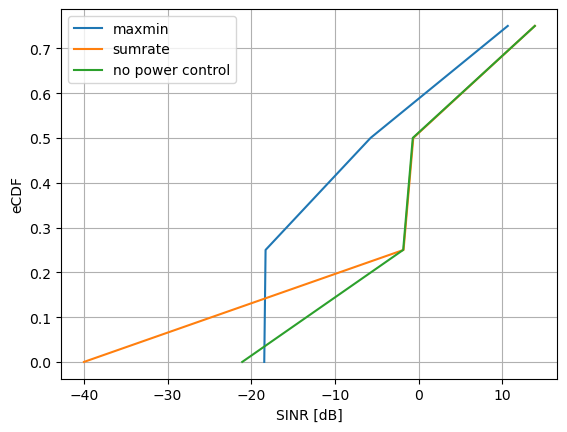

In [32]:
sinr_cdf_noise_maxmin = eCDF(sim_noise.total_sinr_maxmin.flatten())
plt.plot(sinr_cdf_noise_maxmin[0], sinr_cdf_noise_maxmin[1], label='maxmin')

sinr_cdf_noise_sumrate = eCDF(sim_noise.total_sinr_sumrate.flatten())
plt.plot(sinr_cdf_noise_sumrate[0], sinr_cdf_noise_sumrate[1], label='sumrate')

sinr_cdf_noise_npc = eCDF(sim_noise.total_sinr_npc.flatten())
plt.plot(sinr_cdf_noise_npc[0], sinr_cdf_noise_npc[1], label='no power control')


plt.xlabel('SINR [dB]')
plt.ylabel('eCDF')

plt.legend()
plt.grid()

plt.savefig('eCDF SINR noise-limited.jpeg')

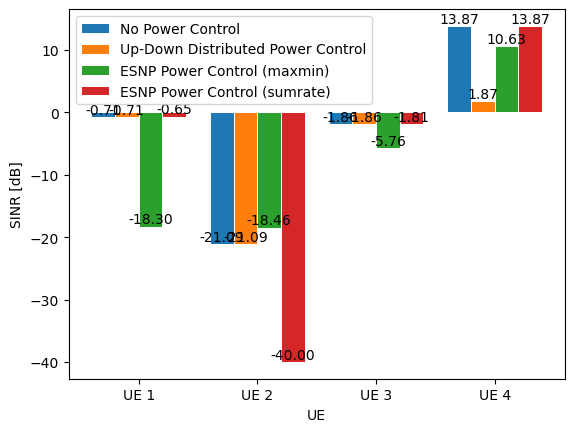

In [33]:
# make data:
x = 0.5 + np.arange(8)
y = [4.8, 5.5, 3.5, 4.6, 6.5, 6.6, 2.6, 3.0]

# plot
fig, ax = plt.subplots()

npc_pow_medians = np.array([
    sim_noise.total_sinr_npc[0][0],
    sim_noise.total_sinr_npc[1][0],
    sim_noise.total_sinr_npc[2][0],
    sim_noise.total_sinr_npc[3][0]
])

ud_pow_medians = np.array([
    sim_noise.total_sinr_ud[0][0],
    sim_noise.total_sinr_ud[1][0],
    sim_noise.total_sinr_ud[2][0],
    sim_noise.total_sinr_ud[3][0]
])

maxmin_pow_medians = np.array([
    sim_noise.total_sinr_maxmin[0][0],
    sim_noise.total_sinr_maxmin[1][0],
    sim_noise.total_sinr_maxmin[2][0],
    sim_noise.total_sinr_maxmin[3][0]
])

sumrate_pow_medians = np.array([
    sim_noise.total_sinr_sumrate[0][0],
    sim_noise.total_sinr_sumrate[1][0],
    sim_noise.total_sinr_sumrate[2][0],
    sim_noise.total_sinr_sumrate[3][0]
])

xs = np.arange(4)
width_ = 0.2

bars1 = ax.bar(xs - width_*1.5, npc_pow_medians, width=width_, edgecolor="white", linewidth=0.7, label='No Power Control')
bars2 = ax.bar(xs - width_*0.5, ud_pow_medians, width=width_, edgecolor="white", linewidth=0.7, label='Up-Down Distributed Power Control')
bars3 = ax.bar(xs + width_*0.5, maxmin_pow_medians, width=width_, edgecolor="white", linewidth=0.7, label='ESNP Power Control (maxmin)')
bars4 = ax.bar(xs + width_*1.5, sumrate_pow_medians, width=width_, edgecolor="white", linewidth=0.7, label='ESNP Power Control (sumrate)')

for bars in [bars1, bars2, bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')

x_labels = ['UE 1', 'UE 2', 'UE 3', 'UE 4']
ax.set_ylabel('SINR [dB]')
ax.set_xlabel('UE')
ax.set_xticks(xs)
ax.set_xticklabels(x_labels)
ax.legend(loc='upper left')

plt.savefig('SINR_noise-limited_esnp.jpeg')

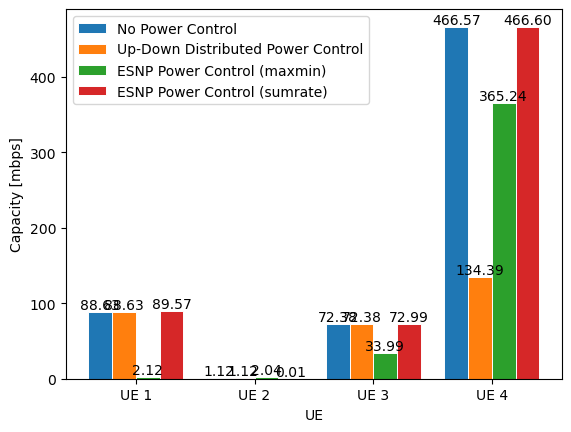

In [34]:
# make data:
x = 0.5 + np.arange(8)
y = [4.8, 5.5, 3.5, 4.6, 6.5, 6.6, 2.6, 3.0]

# plot
fig, ax = plt.subplots()

npc_pow_medians = np.array([
    sim_noise.total_capacity_npc[0][0],
    sim_noise.total_capacity_npc[1][0],
    sim_noise.total_capacity_npc[2][0],
    sim_noise.total_capacity_npc[3][0]
])

ud_pow_medians = np.array([
    sim_noise.total_capacity_ud[0][0],
    sim_noise.total_capacity_ud[1][0],
    sim_noise.total_capacity_ud[2][0],
    sim_noise.total_capacity_ud[3][0]
])

maxmin_pow_medians = np.array([
    sim_noise.total_capacity_maxmin[0][0],
    sim_noise.total_capacity_maxmin[1][0],
    sim_noise.total_capacity_maxmin[2][0],
    sim_noise.total_capacity_maxmin[3][0]
])

sumrate_pow_medians = np.array([
    sim_noise.total_capacity_sumrate[0][0],
    sim_noise.total_capacity_sumrate[1][0],
    sim_noise.total_capacity_sumrate[2][0],
    sim_noise.total_capacity_sumrate[3][0]
])

xs = np.arange(4)
width_ = 0.2

# Create bars for each power control strategy
bars1 = ax.bar(xs - width_ * 1.5, npc_pow_medians, width=width_, edgecolor="white", linewidth=0.7, label='No Power Control')
bars2 = ax.bar(xs - width_ * 0.5, ud_pow_medians, width=width_, edgecolor="white", linewidth=0.7, label='Up-Down Distributed Power Control')
bars3 = ax.bar(xs + width_ * 0.5, maxmin_pow_medians, width=width_, edgecolor="white", linewidth=0.7, label='ESNP Power Control (maxmin)')
bars4 = ax.bar(xs + width_ * 1.5, sumrate_pow_medians, width=width_, edgecolor="white", linewidth=0.7, label='ESNP Power Control (sumrate)')

# Annotate bars with height values
for bars in [bars1, bars2, bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')

# Set labels and legend
x_labels = ['UE 1', 'UE 2', 'UE 3', 'UE 4']
ax.set_ylabel('Capacity [mbps]')
ax.set_xlabel('UE')
ax.set_xticks(xs)
ax.set_xticklabels(x_labels)
ax.legend(loc='upper left')

# Save figure
plt.savefig('capacity_noise-limited_esnp.jpeg')

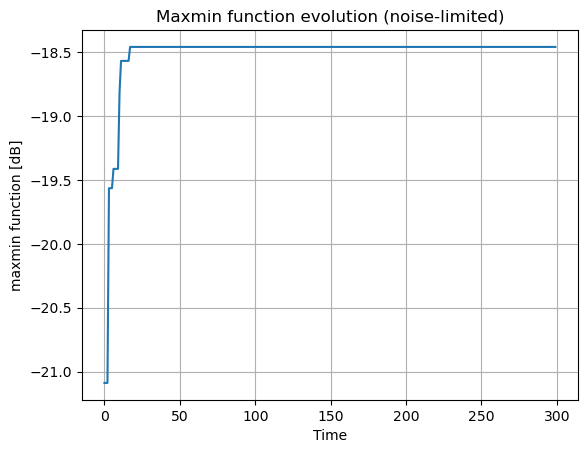

In [35]:
maxmin_vector_noise = np.zeros(total_time)

for time in range(total_time):

    maxmin_vector_noise[time] = np.mean(sim_noise.maxmin_evolution[time, :])
    
#print(sim_noise.maxmin_evolution)
    
plt.plot(np.arange(total_time), maxmin_vector_noise)

plt.grid()
#plt.legend()

plt.title('Maxmin function evolution (noise-limited)')

plt.xlabel('Time')
plt.ylabel('maxmin function [dB]')

plt.savefig('maxmin function evolution noise-limited.jpeg')

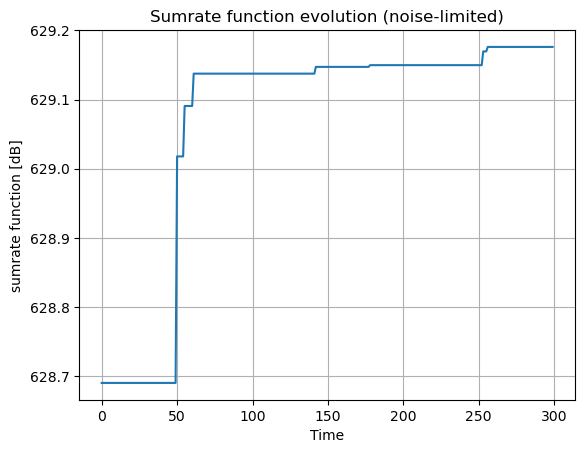

In [37]:
sumrate_vector_noise = np.zeros(total_time)

for time in range(total_time):

    sumrate_vector_noise[time] = np.mean(sim_noise.sumrate_evolution[time, :])
    
#print(sim_noise.maxmin_evolution)
    
plt.plot(np.arange(total_time), sumrate_vector_noise)

plt.grid()
#plt.legend()

plt.title('Sumrate function evolution (noise-limited)')

#plt.ylim(14, 14.2)

plt.xlabel('Time')
plt.ylabel('sumrate function [dB]')

plt.savefig('sumrate function evolution noise-limited.jpeg')

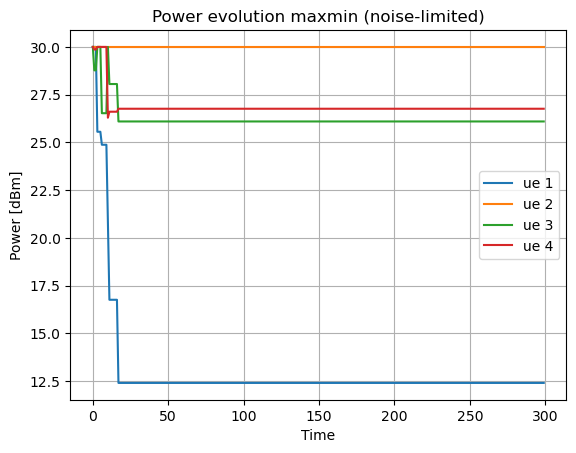

In [38]:
each_power_vector_noise = np.zeros((num_ue, total_time))

for ue in range(num_ue):
    
    for time in range(total_time):
        
        each_power_vector_noise[ue, time] = np.mean(sim_noise.each_power_evolution_maxmin[ue, time, :])

for ue in range(num_ue):
    
    plt.plot(np.arange(total_time), each_power_vector_noise[ue], label=f'ue {ue+1}')

plt.grid()
plt.legend()

plt.title('Power evolution maxmin (noise-limited)')

plt.xlabel('Time')
plt.ylabel('Power [dBm]')

plt.savefig('each power evolution noise-limited maxmin.jpeg')

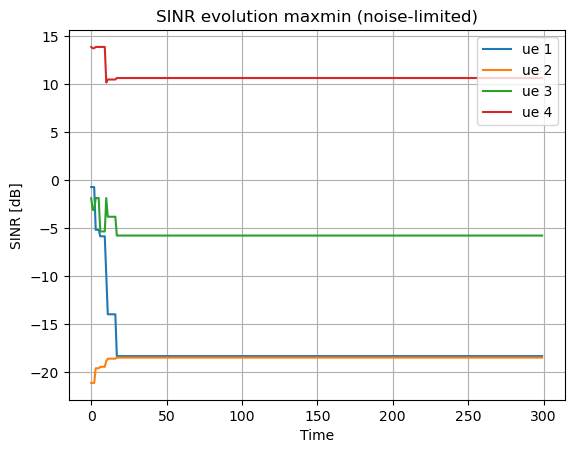

In [39]:
each_sinr_vector_noise = np.zeros((num_ue, total_time))

for ue in range(num_ue):
    
    for time in range(total_time):
        
        each_sinr_vector_noise[ue, time] = np.mean(sim_noise.each_sinr_evolution_maxmin[ue, time, :])

for ue in range(num_ue):
    
    plt.plot(np.arange(total_time), each_sinr_vector_noise[ue], label=f'ue {ue+1}')

plt.grid()
plt.legend()

plt.title('SINR evolution maxmin (noise-limited)')

plt.xlabel('Time')
plt.ylabel('SINR [dB]')

plt.savefig('each sinr evolution noise-limited maxmin.jpeg')

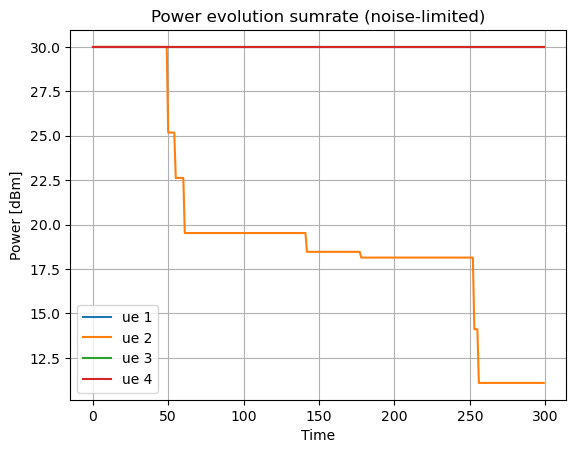

In [40]:
each_power_vector_noise = np.zeros((num_ue, total_time))

for ue in range(num_ue):
    
    for time in range(total_time):
        
        each_power_vector_noise[ue, time] = np.mean(sim_noise.each_power_evolution_sumrate[ue, time, :])

for ue in range(num_ue):
    
    plt.plot(np.arange(total_time), each_power_vector_noise[ue], label=f'ue {ue+1}')

plt.grid()
plt.legend()

plt.title('Power evolution sumrate (noise-limited)')

plt.xlabel('Time')
plt.ylabel('Power [dBm]')

plt.savefig('each power evolution noise-limited sumrate.jpeg')

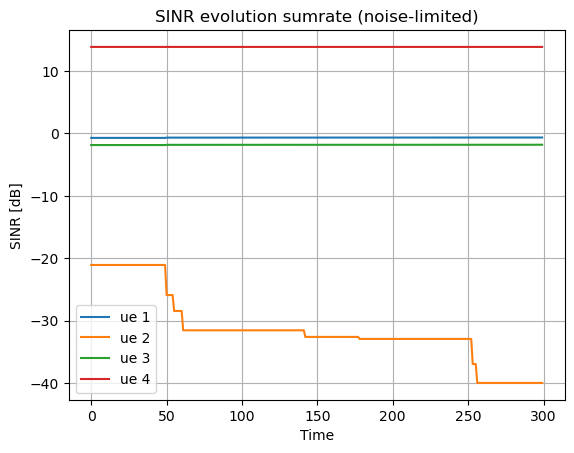

In [41]:
each_sinr_vector_noise = np.zeros((num_ue, total_time))

for ue in range(num_ue):
    
    for time in range(total_time):
        
        each_sinr_vector_noise[ue, time] = np.mean(sim_noise.each_sinr_evolution_sumrate[ue, time, :])

for ue in range(num_ue):
    
    plt.plot(np.arange(total_time), each_sinr_vector_noise[ue], label=f'ue {ue+1}')

plt.grid()
plt.legend()

plt.title('SINR evolution sumrate (noise-limited)')

plt.xlabel('Time')
plt.ylabel('SINR [dB]')

plt.savefig('each sinr evolution noise-limited sumrate.jpeg')

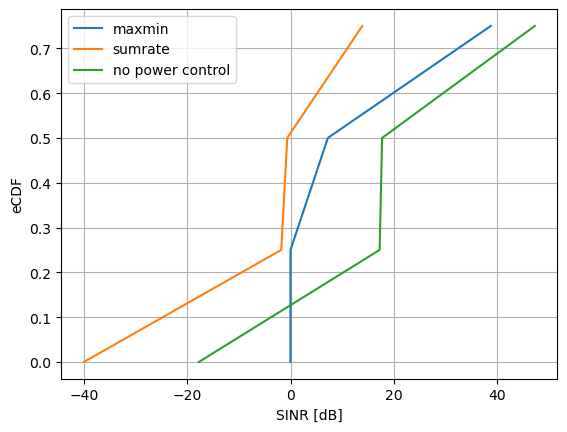

In [42]:
sinr_cdf_interference_maxmin = eCDF(sim_interference.total_sinr_maxmin.flatten())
plt.plot(sinr_cdf_interference_maxmin[0], sinr_cdf_interference_maxmin[1], label='maxmin')

sinr_cdf_interference_sumrate = eCDF(sim_noise.total_sinr_sumrate.flatten())
plt.plot(sinr_cdf_interference_sumrate[0], sinr_cdf_interference_sumrate[1], label='sumrate')

sinr_cdf_interference_npc = eCDF(sim_interference.total_sinr_npc.flatten())
plt.plot(sinr_cdf_interference_npc[0], sinr_cdf_interference_npc[1], label='no power control')


plt.xlabel('SINR [dB]')
plt.ylabel('eCDF')

plt.legend()
plt.grid()

plt.savefig('eCDF SINR interference-limited.jpeg')

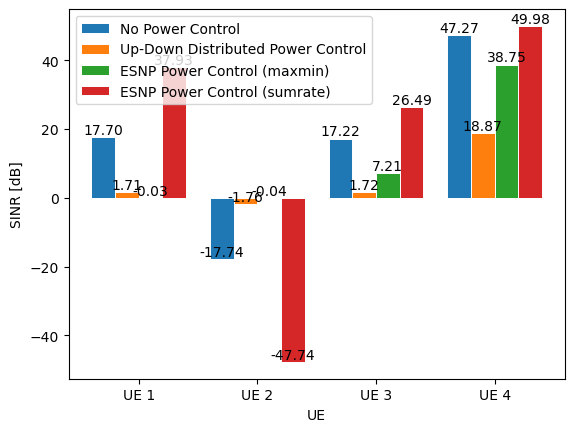

In [43]:
# make data:
x = 0.5 + np.arange(8)
y = [4.8, 5.5, 3.5, 4.6, 6.5, 6.6, 2.6, 3.0]

# plot
fig, ax = plt.subplots()

npc_pow_medians = np.array([
    sim_interference.total_sinr_npc[0][0],
    sim_interference.total_sinr_npc[1][0],
    sim_interference.total_sinr_npc[2][0],
    sim_interference.total_sinr_npc[3][0]
])

ud_pow_medians = np.array([
    sim_interference.total_sinr_ud[0][0],
    sim_interference.total_sinr_ud[1][0],
    sim_interference.total_sinr_ud[2][0],
    sim_interference.total_sinr_ud[3][0]
])

maxmin_pow_medians = np.array([
    sim_interference.total_sinr_maxmin[0][0],
    sim_interference.total_sinr_maxmin[1][0],
    sim_interference.total_sinr_maxmin[2][0],
    sim_interference.total_sinr_maxmin[3][0]
])

sumrate_pow_medians = np.array([
    sim_interference.total_sinr_sumrate[0][0],
    sim_interference.total_sinr_sumrate[1][0],
    sim_interference.total_sinr_sumrate[2][0],
    sim_interference.total_sinr_sumrate[3][0]
])


xs = np.arange(4)
width_ = 0.2

bars1 = ax.bar(xs - width_*1.5, npc_pow_medians, width=width_, edgecolor="white", linewidth=0.7, label='No Power Control')
bars2 = ax.bar(xs - width_*0.5, ud_pow_medians, width=width_, edgecolor="white", linewidth=0.7, label='Up-Down Distributed Power Control')
bars3 = ax.bar(xs + width_*0.5, maxmin_pow_medians, width=width_, edgecolor="white", linewidth=0.7, label='ESNP Power Control (maxmin)')
bars4 = ax.bar(xs + width_*1.5, sumrate_pow_medians, width=width_, edgecolor="white", linewidth=0.7, label='ESNP Power Control (sumrate)')

for bars in [bars1, bars2, bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')
    

x_labels = ['UE 1', 'UE 2', 'UE 3', 'UE 4']
ax.set_ylabel('SINR [dB]')
ax.set_xlabel('UE')
ax.set_xticks(xs)
ax.set_xticklabels(x_labels)
ax.legend(loc='upper left')

plt.savefig('SINR_interference-limited_esnp.jpeg')

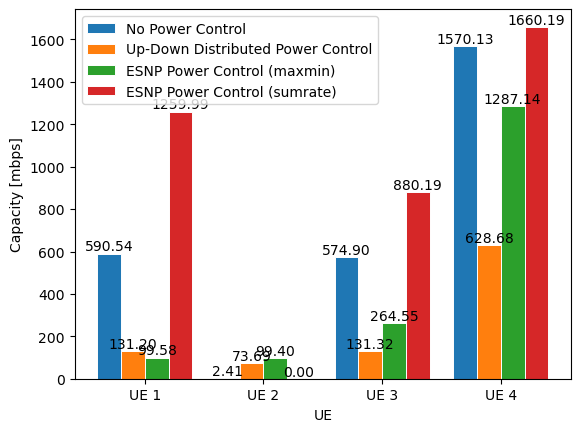

In [44]:
# make data:
x = 0.5 + np.arange(8)
y = [4.8, 5.5, 3.5, 4.6, 6.5, 6.6, 2.6, 3.0]

# plot
fig, ax = plt.subplots()

npc_pow_medians = np.array([
    sim_interference.total_capacity_npc[0][0],
    sim_interference.total_capacity_npc[1][0],
    sim_interference.total_capacity_npc[2][0],
    sim_interference.total_capacity_npc[3][0]
])

ud_pow_medians = np.array([
    sim_interference.total_capacity_ud[0][0],
    sim_interference.total_capacity_ud[1][0],
    sim_interference.total_capacity_ud[2][0],
    sim_interference.total_capacity_ud[3][0]
])

maxmin_pow_medians = np.array([
    sim_interference.total_capacity_maxmin[0][0],
    sim_interference.total_capacity_maxmin[1][0],
    sim_interference.total_capacity_maxmin[2][0],
    sim_interference.total_capacity_maxmin[3][0]
])

sumrate_pow_medians = np.array([
    sim_interference.total_capacity_sumrate[0][0],
    sim_interference.total_capacity_sumrate[1][0],
    sim_interference.total_capacity_sumrate[2][0],
    sim_interference.total_capacity_sumrate[3][0]
])

xs = np.arange(4)
width_ = 0.2

bars1 = ax.bar(xs - width_*1.5, npc_pow_medians, width=width_, edgecolor="white", linewidth=0.7, label='No Power Control')
bars2 = ax.bar(xs - width_*0.5, ud_pow_medians, width=width_, edgecolor="white", linewidth=0.7, label='Up-Down Distributed Power Control')
bars3 = ax.bar(xs + width_*0.5, maxmin_pow_medians, width=width_, edgecolor="white", linewidth=0.7, label='ESNP Power Control (maxmin)')
bars4 = ax.bar(xs + width_*1.5, sumrate_pow_medians, width=width_, edgecolor="white", linewidth=0.7, label='ESNP Power Control (sumrate)')

for bars in [bars1, bars2, bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')

x_labels = ['UE 1', 'UE 2', 'UE 3', 'UE 4']
ax.set_ylabel('Capacity [mbps]')
ax.set_xlabel('UE')
ax.set_xticks(xs)
ax.set_xticklabels(x_labels)
ax.legend(loc='upper left')

plt.savefig('capacity_interference-limited_esnp.jpeg')

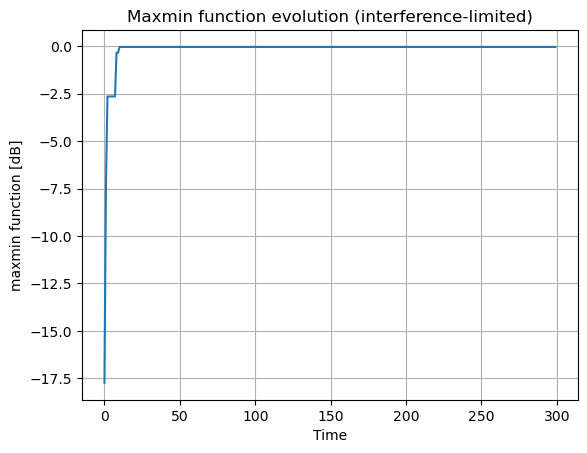

In [45]:
maxmin_vector_interference = np.zeros(total_time)

for time in range(total_time):

    maxmin_vector_interference[time] = np.mean(sim_interference.maxmin_evolution[time, :])
    
#print(sim_interference.maxmin_evolution)
    
plt.plot(np.arange(total_time), maxmin_vector_interference)

plt.grid()
#plt.legend()

plt.title('Maxmin function evolution (interference-limited)')

plt.xlabel('Time')
plt.ylabel('maxmin function [dB]')

plt.savefig('maxmin function evolution interference-limited.jpeg')

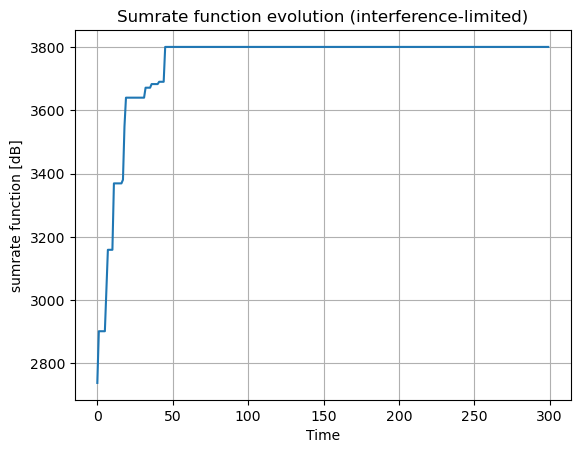

In [46]:
sumrate_vector_interference = np.zeros(total_time)

for time in range(total_time):

    sumrate_vector_interference[time] = np.mean(sim_interference.sumrate_evolution[time, :])
    
#print(sim_interference.maxmin_evolution)
    
plt.plot(np.arange(total_time), sumrate_vector_interference)

plt.grid()
#plt.legend()

plt.title('Sumrate function evolution (interference-limited)')

plt.xlabel('Time')
plt.ylabel('sumrate function [dB]')

plt.savefig('sumrate function evolution interference-limited.jpeg')

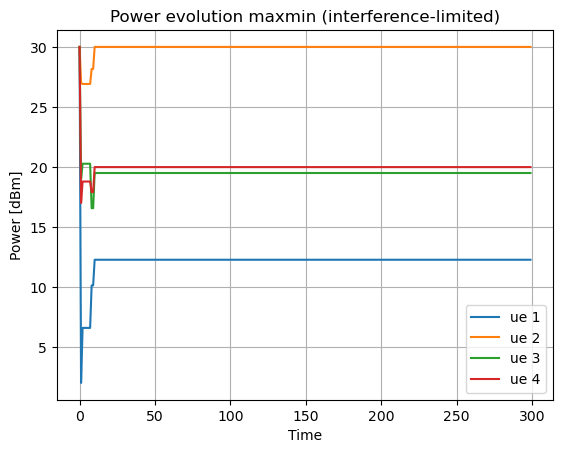

In [47]:
each_power_vector_noise = np.zeros((num_ue, total_time))

for ue in range(num_ue):
    
    for time in range(total_time):
        
        each_power_vector_noise[ue, time] = np.mean(sim_interference.each_power_evolution_maxmin[ue, time, :])

for ue in range(num_ue):
    
    plt.plot(np.arange(total_time), each_power_vector_noise[ue], label=f'ue {ue+1}')

plt.grid()
plt.legend()

plt.title('Power evolution maxmin (interference-limited)')

plt.xlabel('Time')
plt.ylabel('Power [dBm]')

plt.savefig('each power evolution interference-limited maxmin.jpeg')

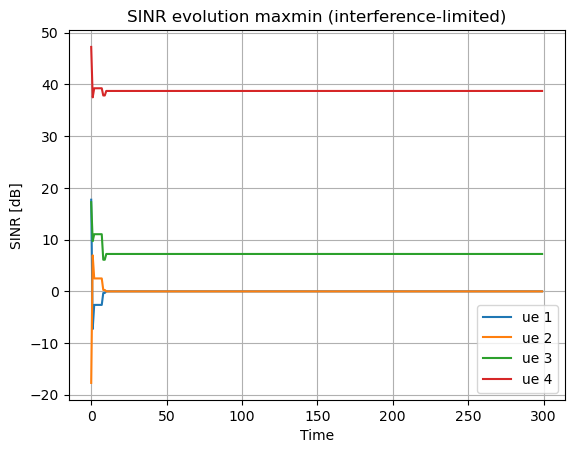

In [48]:
each_sinr_vector_noise = np.zeros((num_ue, total_time))

for ue in range(num_ue):
    
    for time in range(total_time):
        
        each_sinr_vector_noise[ue, time] = np.mean(sim_interference.each_sinr_evolution_maxmin[ue, time, :])

for ue in range(num_ue):
    
    plt.plot(np.arange(total_time), each_sinr_vector_noise[ue], label=f'ue {ue+1}')

plt.grid()
plt.legend()

plt.title('SINR evolution maxmin (interference-limited)')

plt.xlabel('Time')
plt.ylabel('SINR [dB]')

plt.savefig('each sinr evolution interference-limited maxmin.jpeg')

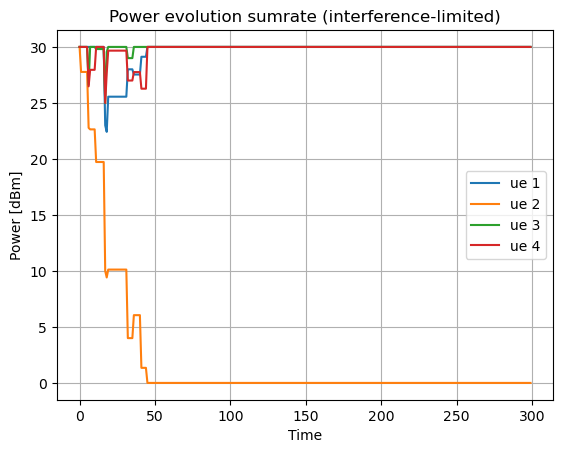

In [49]:
each_power_vector_noise = np.zeros((num_ue, total_time))

for ue in range(num_ue):
    
    for time in range(total_time):
        
        each_power_vector_noise[ue, time] = np.mean(sim_interference.each_power_evolution_sumrate[ue, time, :])

for ue in range(num_ue):
    
    plt.plot(np.arange(total_time), each_power_vector_noise[ue], label=f'ue {ue+1}')

plt.grid()
plt.legend()

plt.title('Power evolution sumrate (interference-limited)')

plt.xlabel('Time')
plt.ylabel('Power [dBm]')

plt.savefig('each power evolution interference-limited sumrate.jpeg')

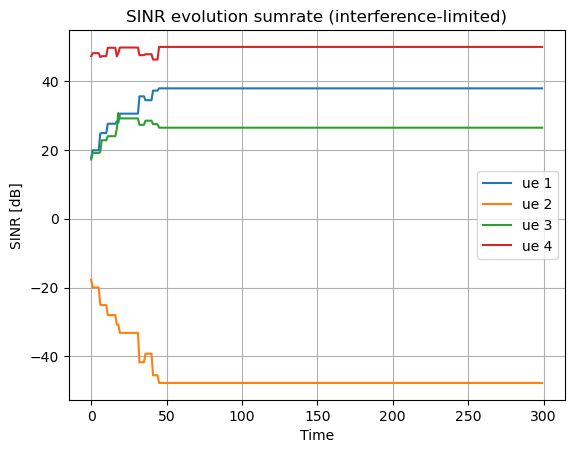

In [50]:
each_sinr_vector_noise = np.zeros((num_ue, total_time))

for ue in range(num_ue):
    
    for time in range(total_time):
        
        each_sinr_vector_noise[ue, time] = np.mean(sim_interference.each_sinr_evolution_sumrate[ue, time, :])

for ue in range(num_ue):
    
    plt.plot(np.arange(total_time), each_sinr_vector_noise[ue], label=f'ue {ue+1}')

plt.grid()
plt.legend()

plt.title('SINR evolution sumrate (interference-limited)')

plt.xlabel('Time')
plt.ylabel('SINR [dB]')

plt.savefig('each sinr evolution interference-limited sumrate.jpeg')